In [1]:
from scripts.data_genertion.consts import *
from scripts.features.feature_extraction import load_all_features

main_df = load_all_features()
main_df[SEQUENCE] = main_df[SEQUENCE].astype(str)

In [2]:
from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

genes_u = ['HIF1A', 'APOL1', 'YAP1', 'SOD1', 'SNCA', 'IRF4', 'KRAS', 'KLKB1', 'SNHG14', 'DGAT2', 'IRF5', 'HTRA1',
           'MYH7', 'MALAT1', 'HSD17B13']
cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [3]:
from scripts.data_genertion.data_handling import get_populated_df_with_structure_features

main_df = get_populated_df_with_structure_features(main_df, genes_u, gene_to_data)

In [4]:
main_df.loc[:, 'mrna_length'] = [len(gene_to_data[gene].full_mrna) for gene in main_df[CANONICAL_GENE]]
main_df['normalized_sense_start_from_end'] = main_df['sense_start_from_end'] / main_df['mrna_length']

In [5]:
import numpy as np
import pandas as pd

first_filtered = main_df.copy()

first_filtered = first_filtered[first_filtered['Cell line organism'] == 'human']
# filtered = filtered[filtered[CANONICAL_GENE] == 'MALAT1']
first_filtered = first_filtered.dropna(subset=[INHIBITION]).copy()
# filtered = filtered.dropna(subset=[DENSITY_UPDATED]).copy()
log_correction = 1.01
first_filtered.loc[:, 'log_inhibition'] = -np.log(log_correction - first_filtered[INHIBITION] / 100)
first_filtered = first_filtered[~first_filtered[CELL_LINE].isin([
    'Hela',  # scanning modifications
    'Human Neuronal Cell',  # scanning modifications;
    'CC-2580',  # scanning modifications
    'SH-SY5Y'  # non pure PS based
])]
# first_filtered = first_filtered[~((first_filtered[CELL_LINE] == 'A431')
#                                   & (first_filtered[CANONICAL_GENE] == 'SOD1'))] # (Kind of) Scanning modifications

mean_metric = 'log_inhibition'
# mean_metric = INHIBITION

# Ensure you remove only the columns you don't want to group by
# cols_except_inhibition = [c for c in first_filtered.columns
#                           if c not in [INHIBITION, mean_metric, 'index']]

# Group by all remaining columns and average log_inhibition
collapsed = (
    first_filtered
    .groupby(['ISIS', VOLUME, TREATMENT_PERIOD, DENSITY_UPDATED, CHEMICAL_PATTERN], as_index=False)[mean_metric]
    .mean()
)

# first_filtered['mean_inhibition'] = first_filtered.groupby('ISIS')[mean_metric].transform('mean')
# first_filtered = first_filtered.drop_duplicates(subset='ISIS').assign(**{mean_metric: first_filtered['mean_inhibition']}).drop(
#     columns='mean_inhibition')

In [6]:
from sklearn.feature_selection import mutual_info_regression, f_regression

# filtered = filtered[filtered['Linkage'] == 'phosphorothioate']

moe_pattern = 'MMMMMddddddddddMMMMM'
# filtered = filtered[filtered['Chemical_Pattern'] == moe_pattern].copy()
# filtered = filtered[filtered[VOLUME] == 2500].copy()
filtered = first_filtered.copy()

filtered['log_volume'] = np.log(filtered[VOLUME])
filtered['log_treatment'] = np.log(filtered[TREATMENT_PERIOD])
li = filtered['log_inhibition']

# filtered['correct_log_inhibition'] = filtered['log_inhibition'] / (filtered['log_volume'])
filtered['correct_log_inhibition'] = li / (filtered[VOLUME] / (filtered[VOLUME] + 10))
filtered['correct_log_inhibition2'] = li / (filtered[VOLUME] * 0.0000601 + 0.537)
# filtered['correct_log_inhibition'] = li



filtered_original = filtered
filtered_original.fillna(0, inplace=True)

ALL_CELL_LINES = filtered_original[CELL_LINE].unique()
non_hepa_cancer = filtered_original[
    # (~((filtered_original[CELL_LINE] == 'HepG2') & (filtered_original[TRANSFECTION].str.contains('Lipo')))) &
    (filtered_original[CELL_LINE] != 'HepG2')  # experiment settings too different
    & (filtered_original[CELL_LINE] != 'HepaRG')  # not similar to cancer
    & (filtered_original[CELL_LINE] != 'A-431')
    & (filtered_original[CELL_LINE] != 'SNU-449')
    ]

metric = 'correct_log_inhibition2'


bad_cols = [INHIBITION, "log_inhibition", "correct_log_inhibition", "correct_log_inhibition2", "ISIS", 'log_volume']
features = (
    # [TREATMENT_PERIOD] +
    [
        col
        for col in non_hepa_cancer.select_dtypes(include=["number"]).columns
        if col not in bad_cols
    ]
)

X = non_hepa_cancer[features]
y = non_hepa_cancer[metric]


/tmp/ipykernel_3992702/2651622118.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_original.fillna(0, inplace=True)


In [13]:
filtered_original[['ggg_d2', SEQUENCE]]

,ggg_d2,Sequence
0,0.0,GCTAAAACAAATGCTA
1,0.0,TATAATGGTGAATATC
2,0.0,GCATGAAGATTTCTGG
3,0.0,GGTGAATATCTTCAAA
4,0.0,CACTTGTACTAGTATG
...,...,...
34760,0.0,GTTATGAAATTATTGG
34761,0.0,ATTCTATTAGAGGGCT
34762,0.0,GCTTTAAACTCAGGTG
34763,0.0,CGTCAATATATTCTTT


Cell line: A431, gene KRAS, amount: 925
Pearson r = -0.070, p = 3.37e-02
Spearman r = -0.114, p = 5.40e-04
Fit: y = -0.000x + 6.565


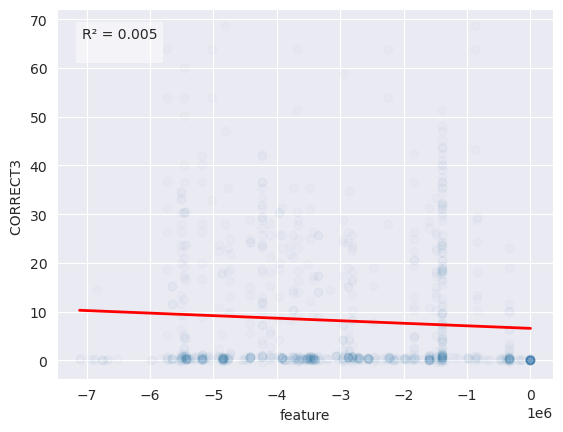

Cell line: A431, gene MALAT1, amount: 3053
Pearson r = 0.242, p = 8.12e-42
Spearman r = 0.251, p = 4.78e-45
Fit: y = 0.000x + 1.365


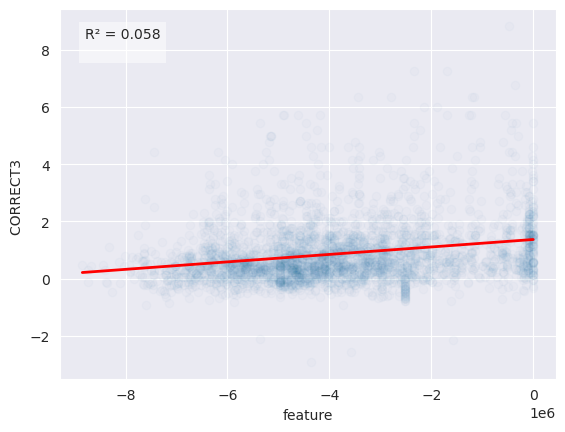

Cell line: A431, gene SOD1, amount: 429
Pearson r = 0.356, p = 3.11e-14
Spearman r = 0.392, p = 3.28e-17
Fit: y = 0.000x + 0.442


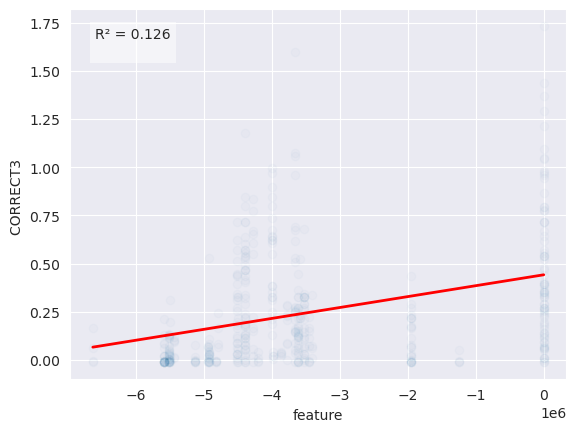

Cell line: A431, gene APOL1, amount: 2134
Pearson r = 0.139, p = 1.06e-10
Spearman r = 0.151, p = 1.99e-12
Fit: y = 0.000x + 1.664


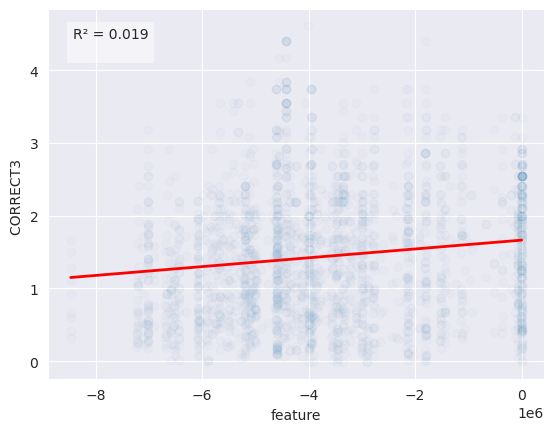

Cell line: SK-MEL-28, gene IRF4, amount: 2836
Pearson r = nan, p = nan
Spearman r = nan, p = nan
Whoops


/tmp/ipykernel_3992702/4071267007.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_p, p_p = pearsonr(x, y)
/tmp/ipykernel_3992702/4071267007.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_s, p_s = spearmanr(x, y)


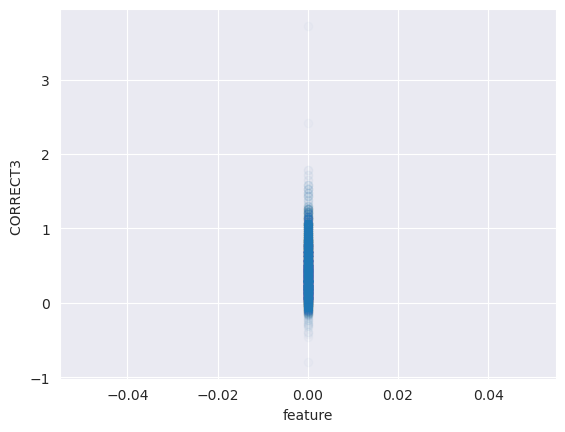

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

filtered_original['correct_log_inhibition3'] = filtered_original['correct_log_inhibition2'] / (-0.032*  filtered_original[TREATMENT_PERIOD] + 2.36)


try:
    for cell_line in ['A431', 'SK-MEL-28', 'MM.1R', 'KARPAS-229']:
        genes = filtered_original[filtered_original[CELL_LINE] == cell_line][CANONICAL_GENE].unique()
        for gene in genes:
    # for cell_line in ['HepaRG']:
    # for cell_line in ['A431']:
            test_df = filtered_original[(filtered_original[CELL_LINE] == cell_line) & (filtered_original[CANONICAL_GENE] == gene)]
            # only_cancer_not_nan = filtered_original[(filtered_original[CELL_LINE] == 'HepG2') | (filtered_original[CELL_LINE] == 'HepaRG')]
            # only_cancer_not_nan = filtered_original[(filtered_original[CELL_LINE] == 'SNU-449')]
            # only_cancer_not_nan = only_cancer[only_cancer['CAI_score_70_CDS'].notna()]
            # test_df = test_df[test_df['ggg_d1'] != 0]
            print(f"Cell line: {cell_line}, gene {gene}, amount: {len(test_df)}")
            x = test_df['off_target.top200.cutoff600.premRNA_TPM']
            y = test_df['correct_log_inhibition3']

            plt.clf()
            plt.scatter(x, y, alpha=0.02)
            plt.xlabel('feature')
            plt.ylabel('CORRECT3 ')

            # === toggle fit type ===
            use_quadratic = False  # set False for linear

            xs = np.linspace(np.nanmin(x), np.nanmax(x), 500)

            # Correlations
            r_p, p_p = pearsonr(x, y)
            r_s, p_s = spearmanr(x, y)

            print(f"Pearson r = {r_p:.3f}, p = {p_p:.2e}")
            print(f"Spearman r = {r_s:.3f}, p = {p_s:.2e}")

            if use_quadratic:
                # Quadratic fit
                a, b, c = np.polyfit(x, y, 2)
                ys = a * xs ** 2 + b * xs + c
                y_pred = a * x ** 2 + b * x + c
                fit_label = f"y = {a:.3f}x² + {b:.3f}x + {c:.3f}"
            else:
                # Linear fit
                m, b = np.polyfit(x, y, 1)
                ys = m * xs + b
                y_pred = m * x + b
                fit_label = f"y = {m:.3f}x + {b:.3f}"

            plt.plot(xs, ys, color="red", linewidth=2)

            print("Fit:", fit_label)

            # R²
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            r2 = 1 - ss_res / ss_tot

            plt.text(0.05, 0.95,
                     f"R² = {r2:.3f}\n",
                     # f"Spearman r = {r_s:.3f}, p = {p_s:.2e}",
                     transform=plt.gca().transAxes,
                     ha="left", va="top",
                     fontsize=10,
                     bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))

            plt.show()
except Exception:
    print("Whoops")

In [53]:
bad_cols = [INHIBITION, "log_inhibition", "correct_log_inhibition", "correct_log_inhibition2", "ISIS", 'log_volume', VOLUME, 'tAI_score_global_CDS', 'CAI_score_40_CDS', 'mrna_length', 'sense_utr', 'ASO_gc_skew', 'CAI_score_global_CDS', 'gc_skew', 'CAI_score_70_CDS', 'Location_div_by_length', 'on_target_fold_openness40_15', 'ENC_score_global_CDS']


In [50]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from math import atanh, sqrt, tanh

TARGET = "correct_log_inhibition3"

def _clean_xy(df, feats, target):
    X = df.loc[:, feats].apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(df[target], errors="coerce")
    # drop columns with any NaNs; then drop rows with NaN in y
    X = X.loc[:, X.notna().all(axis=0)]
    mask = y.notna()
    X = X.loc[mask]
    y = y.loc[mask].astype(float).values
    return X, y

def _spearman_for_all(X, y):
    rhos, pvals = [], []
    for col in X.columns:
        rho, p = pearsonr(X[col].values, y)
        rhos.append(rho)
        pvals.append(p)
    return pd.DataFrame({"feature": X.columns, "rho": rhos, "p": pvals})

def _bh_fdr(p, alpha=0.05):
    p = np.asarray(p, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    thresh = alpha * (np.arange(1, n+1) / n)
    passed = np.zeros(n, dtype=bool)
    if np.any(ranked <= thresh):
        kmax = np.max(np.where(ranked <= thresh)[0])
        passed[:kmax+1] = True
    # map back to original order
    out = np.zeros(n, dtype=bool)
    out[order] = passed
    return out

def _fisher_z_diff(r1, n1, r2, n2):
    """Two-sided p-value for difference in independent correlations via Fisher z."""
    # guard for |r|=1
    r1 = np.clip(r1, -0.999999, 0.999999)
    r2 = np.clip(r2, -0.999999, 0.999999)
    z1, z2 = atanh(r1), atanh(r2)
    se = sqrt(1/(n1-3) + 1/(n2-3)) if (n1>3 and n2>3) else np.inf
    z = (z1 - z2) / se if np.isfinite(se) else 0.0
    # two-sided p from z (normal)
    from math import erf
    p = 2 * (1 - 0.5*(1 + erf(abs(z)/sqrt(2))))
    return z, p

def find_sign_flip_features(filtered_original, features, cell_a, cell_b, *,
                            target_col=TARGET, min_abs_rho=0.15, fdr_alpha=0.05):
    # slice per cell line
    A = filtered_original[filtered_original[CELL_LINE] == cell_a].copy()
    B = filtered_original[filtered_original[CELL_LINE] == cell_b].copy()

    XA, ya = _clean_xy(A, features, target_col)
    XB, yb = _clean_xy(B, features, target_col)

    # keep only features present (non-NaN) in both subsets
    common = XA.columns.intersection(XB.columns).tolist()
    XA, XB = XA[common], XB[common]

    # Spearman per cell line
    dfA = _spearman_for_all(XA, ya).rename(columns={"rho": "rho_A", "p": "p_A"})
    dfB = _spearman_for_all(XB, yb).rename(columns={"rho": "rho_B", "p": "p_B"})
    res = dfA.merge(dfB, on="feature", how="inner")
    res["n_A"] = len(ya)
    res["n_B"] = len(yb)

    # sign flip & strength
    res["sign_flip"] = np.sign(res["rho_A"]) * np.sign(res["rho_B"]) == -1
    res["min_abs_rho"] = np.minimum(res["rho_A"].abs(), res["rho_B"].abs())
    res["sum_abs_rho"] = res["rho_A"].abs() + res["rho_B"].abs()

    # Fisher z test for difference in correlations
    zs, ps = [], []
    for r1, r2, n1, n2 in zip(res["rho_A"], res["rho_B"], res["n_A"], res["n_B"]):
        z, p = _fisher_z_diff(r1, n1, r2, n2)
        zs.append(z); ps.append(p)
    res["z_diff"] = zs
    res["p_diff"] = ps

    # FDR on per-cell p-values and on diff p-value
    res["A_sig_fdr"] = _bh_fdr(res["p_A"].values, alpha=fdr_alpha)
    res["B_sig_fdr"] = _bh_fdr(res["p_B"].values, alpha=fdr_alpha)
    res["diff_sig_fdr"] = _bh_fdr(res["p_diff"].values, alpha=fdr_alpha)

    # priority score: opposite, strong in both, all three FDRs pass
    res["priority"] = (
        res["sign_flip"]
        & (res["min_abs_rho"] >= min_abs_rho)
        & res["A_sig_fdr"] & res["B_sig_fdr"] & res["diff_sig_fdr"]
    )

    # sort: flagged first, then by strength of flip
    res = res.sort_values(
        by=["priority", "min_abs_rho", "sum_abs_rho"],
        ascending=[False, False, False]
    ).reset_index(drop=True)

    return res

# --- example usage ---
cell_a = "SK-MEL-28"
cell_b = "A431"   # change as needed
flip_df = find_sign_flip_features(filtered_original, features, cell_a, cell_b,
                                  target_col="correct_log_inhibition3",
                                  min_abs_rho=0.15, fdr_alpha=0.05)

# top candidates with robust opposite correlation
print(flip_df.loc[flip_df["priority"],
                  ["feature","rho_A","p_A","rho_B","p_B","p_diff","min_abs_rho","sum_abs_rho"]]
      .head(25))

# if you want everything, sorted by strength:
print(flip_df[flip_df['sign_flip'] == True].head(50))


/tmp/ipykernel_3992702/3420913451.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = pearsonr(X[col].values, y)


                            feature     rho_A           p_A     rho_B           p_B  p_diff  min_abs_rho  sum_abs_rho
0                        sense_exon  0.275899  1.023646e-50 -0.199635  8.789889e-60     0.0     0.199635     0.475534
1                  CAI_score_70_CDS  0.306419  1.026545e-62 -0.189882  3.734816e-54     0.0     0.189882     0.496302
2                  ENC_score_70_CDS  0.276147  8.293093e-51 -0.189790  4.208883e-54     0.0     0.189790     0.465937
3                  CAI_score_60_CDS  0.302221  5.626503e-61 -0.189745  4.460401e-54     0.0     0.189745     0.491966
4                  CAI_score_50_CDS  0.305079  3.714200e-62 -0.189410  6.872389e-54     0.0     0.189410     0.494489
5                  ENC_score_60_CDS  0.286914  7.081298e-55 -0.189301  7.908150e-54     0.0     0.189301     0.476215
6                  CAI_score_20_CDS  0.306850  6.783822e-63 -0.189187  9.161946e-54     0.0     0.189187     0.496037
7                  ENC_score_50_CDS  0.283481  1.468858e

In [51]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def screen_interactions(df, ycol, f1, candidates, min_n=100):
    """
    For two given 'flip' features (f1, f2), screen all candidate features for best interaction with them.
    Returns a summary DataFrame with interaction significance.
    """
    results = []
    for f in [f1]:
        for g in candidates:
            if g in [f1, ycol]:
                continue
            # clean
            sub = df[[ycol, f, g]].dropna()
            if len(sub) < min_n:
                continue
            # simple OLS with interaction
            formula = f"{ycol} ~ {f} + {g} + {f}:{g}"
            try:
                model = smf.ols(formula, data=sub).fit()
                p_int = model.pvalues.get(f"{f}:{g}", np.nan)
                coef_int = model.params.get(f"{f}:{g}", np.nan)
                results.append({
                    "base_feature": f,
                    "candidate": g,
                    "coef_int": coef_int,
                    "p_int": p_int,
                    "r2": model.rsquared
                })
            except Exception as e:
                continue
    out = pd.DataFrame(results)
    return out.sort_values("p_int").reset_index(drop=True)

# Example usage:
candidates = features   # all features you already have
res = screen_interactions(filtered_original,
                          ycol="correct_log_inhibition3",
                          f1="sense_intron",
                          candidates=candidates)



In [52]:
# sort by R² descending and print full table
res = res.sort_values("r2", ascending=False).reset_index(drop=True)

# don’t truncate columns/rows in display
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.max_colwidth", None)

print(res.head(10))   # will show all rows sorted by R²

   base_feature                        candidate  coef_int          p_int        r2
0  sense_intron                    log_treatment  2.440350  8.414247e-111  0.092636
1  sense_intron             Location_in_sequence  0.000029   1.602146e-56  0.024157
2  sense_intron                      sense_start  0.000029   1.602146e-56  0.024157
3  sense_intron  normalized_sense_start_from_end -1.803599   2.187676e-34  0.020108
4  sense_intron                 normalized_start  1.781681   1.299166e-33  0.019797
5  sense_intron           Location_div_by_length  1.781681   1.299166e-33  0.019797
6  sense_intron            premRNA_gc_content_70 -4.413474   6.230582e-20  0.015344
7  sense_intron                      mrna_length  0.000021   1.857230e-30  0.014771
8  sense_intron            premRNA_gc_content_50 -5.103718   2.835492e-27  0.014361
9  sense_intron                            index -0.000011   8.186353e-03  0.014246
